<a href="https://colab.research.google.com/github/RichardMuri/MIT_6864/blob/main/Copy_of_6864_hw2_fa21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf MIT_6864
git clone \
  --depth 1  \
  --filter=blob:none  \
  --no-checkout \
  https://github.com/RichardMuri/MIT_6864
cd MIT_6864
git checkout main -- Homework_2/reviews.csv Homework_2/lab_util.py ML_utilities.py

Cloning into 'MIT_6864'...


In [3]:
import sys
sys.path.append("/content/MIT_6864/Homework_2")
import csv
import itertools as it
import numpy as np
import sklearn.decomposition
np.random.seed(0)
from tqdm import tqdm

import lab_util

sys.path.append("/content/MIT_6864/")
import ML_utilities
from ML_utilities import assert_size
from pdb import set_trace as st


# Introduction

In this notebook, you will find code scaffolding for the implementation portion of Homework 2. There are certain parts of the scaffolding marked with `# Your code here!` comments where you can fill in code to perform the specified tasks. After implementing the methods in this notebook, you will need to design and perform experiments to evaluate each method and respond to the questions in the Homework 2 handout (available on Canvas). You should be able to complete this assignment without changing any of the scaffolding code, just writing code to fill in the scaffolding and run experiments.

## Dataset

We're going to be working with a dataset of product reviews. The following cell loads the dataset and splits it into training, validation, and test sets.

In [4]:
data = []
n_positive = 0
n_disp = 0
with open("/content/MIT_6864/Homework_2/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue
      n_positive += 1
    if len(data) == 4000:
      break

    data.append((review, label))
    
    if n_disp > 5:
      continue
    n_disp += 1
    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")
np.random.shuffle(data)
reviews, labels = zip(*data)
train_reviews = reviews[:3000]
train_labels = labels[:3000]
val_reviews = reviews[3000:3500]
val_labels = labels[3000:3500]
test_reviews = reviews[3500:]
test_labels = labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

# Part 1: word representations via matrix factorization

First, we'll construct the term-document matrix (look at `/content/hw2/lab_util.py` in the file browser on the left if you want to see how this works).

In [5]:
vectorizer = lab_util.CountVectorizer()
vectorizer.fit(train_reviews)
td_matrix = vectorizer.transform(train_reviews).T
print(f"TD matrix is {td_matrix.shape[0]} x {td_matrix.shape[1]}")

TD matrix is 2006 x 3000


First, implement the function `learn_reps_lsa` that computes word representations via latent semantic analysis. The `sklearn.decomposition` or `np.linalg` packages may be useful.

In [34]:
import sklearn.decomposition
def learn_reps_lsa(matrix, rep_size):
    # `matrix` is a `|V| x n` matrix (usually a TD matrix), 
    # where `|V|` is the number of words in the vocabulary and `n`
    # is the number of reviews in the (training) corpus.
    # This function should return a `|V| x rep_size` matrix with each
    # row corresponding to a word representation.

    # Your code here!
    vsize = len(matrix)
    # In this case, using just U
    U, sigma, V = np.linalg.svd(matrix, full_matrices=True)
    result = U[:, :rep_size]
    assert_size(result, [vsize, rep_size])
    return result

#### Sanity check 1
The following cell contains a simple sanity check for your `learn_reps_lsa` implementation: it should print `True` if your `learn_reps_lsa` function is implemented equivalently to one of our solutions.  There are at least two reasonable ways to formulate these LSA word representations (whether you directly use the left singular vectors of `matrix` or scale them by the singular values), these correspond to the two possible representations in the sanity check below.

In [7]:
DEBUG_sc1_matrix = np.array([[1,0,0,2,1,3,5],
                             [2,0,0,0,0,4,0],
                             [0,3,4,1,8,6,6],
                             [1,4,5,0,0,0,0]])

DEBUG_reps = learn_reps_lsa(DEBUG_sc1_matrix, 3)
DEBUG_gt1 = np.array([[ -4.92017554,  -2.85465774,   1.18575453],
                      [ -2.14977584,  -1.19987977,   3.37221899],
                      [-12.62664695,   0.10890093,  -1.32131745],
                      [ -2.69216011,   5.66453534,   1.33728063]])
DEBUG_gt2 = np.array([[-0.35188159, -0.44213061,  0.29358929],
                      [-0.15374788, -0.18583789,  0.83495136],
                      [-0.90303377,  0.01686662, -0.32715426],
                      [-0.19253817,  0.87732566,  0.3311067 ]])

print(np.allclose(np.abs(DEBUG_reps), np.abs(DEBUG_gt1)) or np.allclose(np.abs(DEBUG_reps), np.abs(DEBUG_gt2)))

True


Let's look at some representations:

In [8]:
reps = learn_reps_lsa(td_matrix, 500)
words = ["good", "bad", "cookie", "jelly", "dog", "the", "3"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

good 47
  gerber 1.873
  luck 1.885
  crazy 1.890
  flaxseed 1.906
  suspect 1.907
bad 201
  disgusting 1.625
  horrible 1.776
  shortbread 1.778
  gone 1.778
  dont 1.802
cookie 504
  nana's 0.964
  bars 1.363
  odd 1.402
  impossible 1.459
  cookies 1.484
jelly 351
  twist 1.099
  cardboard 1.197
  peanuts 1.311
  advertised 1.331
  plastic 1.510
dog 925
  happier 1.670
  earlier 1.681
  eats 1.702
  stays 1.722
  standard 1.727
the 36
  suspect 1.953
  flowers 1.961
  leaked 1.966
  m 1.966
  burn 1.967
3 289
  omega 1.733
  vendor 1.739
  supermarket 1.747
  nutty 1.755
  carries 1.797


We've been operating on the raw count matrix, but in class we discussed several reweighting schemes aimed at making LSA representations more informative. 

Here, implement the TF-IDF transform and see how it affects learned representations. While it is okay (and in fact encouraged) to use vectorized numpy operations, you should refrain from using pre-implemented library functions for computing TF-IDF.

In [9]:
def transform_tfidf(matrix):
    # `matrix` is a `|V| x |D|` TD matrix of raw counts, where `|V|` is the 
    # vocabulary size and `|D|` is the number of documents in the corpus. This
    # function should return a version of `matrix` with the TF-IDF transform
    # applied. Note: this function should be nondestructive: it should not
    # modify the input; instead, it should return a new object.

    # Your code here!
    nwords, ndocs = matrix.shape
    vidf = np.vectorize(idf_helper)
    idfs = np.zeros(nwords)
    for i, _ in enumerate(idfs):
      idfs[i] = idf_helper(matrix[i,:], ndocs)
    tfidf = np.multiply(matrix, idfs[:, np.newaxis])
    assert_size(tfidf, matrix.shape)
    return tfidf

def idf_helper(row, ndocs):
  df = np.count_nonzero(row)
  idf = np.log(ndocs/df)
  return idf
  


#### Sanity check 2
The following cell should print `True` if your `transform_tfidf` function is implemented properly. (*Hint: in our implementation, we use the natural logarithm (base $e$) when computing inverse document frequency.*)

In [10]:
DEBUG_sc2_matrix = np.array([[3,1,0,3,0],
                             [0,2,0,0,1],
                             [7,8,2,0,1],
                             [1,9,8,1,0]])
DEBUG_gt = np.array([[1.53247687, 0.51082562, 0.        , 1.53247687, 0.        ],
                     [0.        , 1.83258146, 0.        , 0.        , 0.91629073],
                     [1.56200486, 1.78514841, 0.4462871 , 0.        , 0.22314355],
                     [0.22314355, 2.00829196, 1.78514841, 0.22314355, 0.        ]])
print(np.allclose(transform_tfidf(DEBUG_sc2_matrix), DEBUG_gt))

True


How does TF-IDF normalization change the learned similarity function?


In [35]:
reps = 100
td_matrix_tfidf = transform_tfidf(td_matrix)
reps_tfidf = learn_reps_lsa(td_matrix_tfidf, reps)
lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)

good 47
  everyone 1.078
  lunches 1.089
  as 1.145
  pretty 1.182
  but 1.199
bad 201
  taste 1.038
  strange 1.084
  like 1.152
  myself 1.169
  nasty 1.177
cookie 504
  cookies 0.346
  nana's 0.517
  oreos 0.698
  bars 0.796
  craving 1.026
jelly 351
  creamer 0.891
  gifts 1.008
  twist 1.044
  packages 1.150
  advertised 1.179
dog 925
  foods 0.996
  switched 1.044
  pet 1.096
  loves 1.147
  appeal 1.150
the 36
  of 0.906
  <unk> 0.976
  . 1.053
  and 1.142
  to 1.194
3 289
  1 1.095
  2 1.108
  4 1.127
  vendor 1.154
  cool 1.242


Now that we have some representations, let's see if we can do something useful with them.

Below, implement a feature function that represents a document as the sum of its
learned word embeddings.

The remaining code trains a logistic regression model on a set of *labeled* reviews; we're interested in seeing how much representations learned from *unlabeled* reviews improve classification.

(Note: the staff solutions for each of the three featurizers achieve accuracies of between .78 and .83 with the full training corpus (3000 examples).)

In [36]:
import sklearn.linear_model
import sklearn.model_selection

def word_featurizer(xs):
    # normalize
    return xs / np.sqrt((xs ** 2).sum(axis=1, keepdims=True))

def lsa_featurizer(xs):
    # This function takes in a `|V| x |D|` TD matrix in which each row contains
    # the word counts for the given review.
    # It should return a matrix where each row contains the learned feature
    # representation of each review (e.g. the sum of LSA word representations).
    # (Hint: use TF-IDF LSA features, which should be a global variable after
    # running the previous cell; no need to pass it in as an argument.)

    lsa = reps_tfidf
    feats = xs @ lsa

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

# We've implemented the remainder of the training and evaluation pipeline,
# so you likely won't need to modify the following four functions.
def combo_featurizer(xs):
    return np.concatenate((word_featurizer(xs), lsa_featurizer(xs)), axis=1)

def train_model(featurizer, xs, ys):
    xs_featurized = featurizer(xs)
    model = sklearn.linear_model.LogisticRegression()
    model.fit(xs_featurized, ys)
    return model

def eval_model(model, featurizer, xs, ys):
    xs_featurized = featurizer(xs)
    pred_ys = model.predict(xs_featurized)
    return np.mean(pred_ys == ys)

def training_experiment(name, featurizer, n_train):
    print(f"{name} features, {n_train} examples")
    train_xs = vectorizer.transform(train_reviews[:n_train])
    train_ys = train_labels[:n_train]
    test_xs = vectorizer.transform(test_reviews)
    test_ys = test_labels
    model = train_model(featurizer, train_xs, train_ys)
    acc = eval_model(model, featurizer, test_xs, test_ys)
    print(acc, '\n')
    return acc

# The following four lines will run a training experiment with all 3k examples
# in training set for each feature type. `training_experiment` may be useful to
# you when performing experiments to answer questions in the handout.
n_train = 3000
training_experiment("word", word_featurizer, n_train)
training_experiment("lsa", lsa_featurizer, n_train)
training_experiment("combo", combo_featurizer, n_train)
print()

word features, 3000 examples
0.784 

lsa features, 3000 examples
0.798 

combo features, 3000 examples
0.802 




**Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above, as well as your answers to the questions in Part 1 of the Homework 2 handout. Below, you can set up and perform experiments that answer these questions (include figures, plots, and tables in your write-up as you see fit).

## Experiments for Part 1

In [17]:
# # Your code here!
# def run_exp(n_train):
#   acc_w = training_experiment("word", word_featurizer, n_train)
#   acc_l = training_experiment("lsa", lsa_featurizer, n_train)
#   acc_c = training_experiment("combo", combo_featurizer, n_train)
#   return acc_w, acc_l, acc_c

# td_matrix_tfidf = transform_tfidf(td_matrix)
# reps = range(100, 2006, 200)
# n_trains = range(500, 3001, 500)
# nexps = len(reps) * len(n_trains)
# acc_w = np.zeros([nexps])
# acc_l = np.zeros([nexps])
# acc_c = np.zeros([nexps])
# rvals = np.zeros([nexps])
# tvals = np.zeros([nexps])
# count = 0
# for i, rep in enumerate(reps):
#   reps_tfidf = learn_reps_lsa(td_matrix_tfidf, rep)
#   for j, n_train in enumerate(n_trains):
#     acc_w[count], acc_l[count], acc_c[count] = run_exp(n_train)
#     rvals[count] = rep
#     tvals[count] = n_train
#     count = count + 1

Text(0.5, 0.92, 'LSA Featurizer Performance')

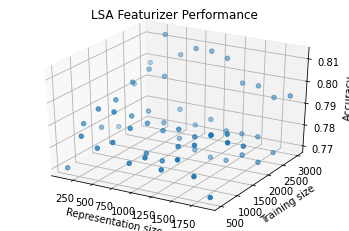

In [18]:
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(rvals, tvals, acc_l)
# ax.set_xlabel('Representation size')
# ax.set_ylabel('Training size')
# ax.set_zlabel('Accuracy')
# ax.set_title('LSA Featurizer Performance')

Text(0.5, 0.92, 'Word Featurizer Performance')

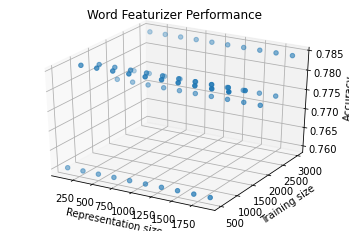

In [19]:
# fig2 = plt.figure()
# ax = fig2.add_subplot(projection='3d')
# ax.scatter(rvals, tvals, acc_w)
# ax.set_xlabel('Representation size')
# ax.set_ylabel('Training size')
# ax.set_zlabel('Accuracy')
# ax.set_title('Word Featurizer Performance')

LSA max: 0.812 Word max: 0.784 Combo max: 0.818


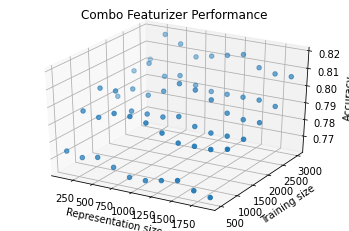

In [20]:
# fig3 = plt.figure()
# ax = fig3.add_subplot(projection='3d')
# ax.scatter(rvals, tvals, acc_c)
# ax.set_xlabel('Representation size')
# ax.set_ylabel('Training size')
# ax.set_zlabel('Accuracy')
# ax.set_title('Combo Featurizer Performance')

# lmax = np.max(acc_l)
# wmax = np.max(acc_w)
# cmax = np.max(acc_c)
# print(f'LSA max: {lmax} Word max: {wmax} Combo max: {cmax}')

## Part 2: word representations via language modeling

In this section, we'll train a word embedding model with a word2vec-style objective rather than a matrix factorization objective. This requires a little more work; we've provided scaffolding for a PyTorch model implementation below.
If you don't have much PyTorch experience, there are some tutorials [here](https://pytorch.org/tutorials/) which may be useful. You're also welcome to implement these experiments in any other framework of your choosing (note that we won't be able to provide debugging support if you use a different framework).

In [29]:
def learn_reps_word2vec(corpus, window_size, rep_size, n_epochs, n_batch):
    #This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of 
    # the assignment. (You can extract this matrix from the parameters of the 
    # Word2VecModel.)

    tokenizer = lab_util.Tokenizer()
    tokenizer.fit(corpus)
    tokenized_corpus = tokenizer.tokenize(corpus)
    vsize = tokenizer.vocab_size
    print(f"Tokenizer size is {vsize}")

    ngrams = lab_util.get_ngrams(tokenized_corpus, window_size, pad_idx=vsize)
    print(f"Ngrams size is {len(ngrams)}")

    device = torch.device('cuda')  # run on colab gpu
    model = Word2VecModel(vsize, rep_size).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    # What loss function should we use for Word2Vec?
    loss_fn = nn.CrossEntropyLoss(ignore_index=vsize)  # Your code here!

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
            # As described above, `context` is a batch of context word ids, and
            # `label` is a batch of predicted word labels.

            # Here, perform a forward pass to compute predictions for the model.
            # Your code here!
            preds = model(context.to(device))


            # Now finish the backward pass and gradient update.
            # Remember, you need to compute the loss, zero the gradients
            # of the model parameters, perform the backward pass, and
            # update the model parameters.
            # Your code here!
            loss = loss_fn(preds, label.to(device))
            loss.backward()
            opt.step()
            model.zero_grad()
            epoch_loss += loss.item()
        losses.append(epoch_loss)
        print("Epoch {} loss: {}".format(epoch, epoch_loss))
    

    # Hint: you want to return a `vocab_size x embedding_size` numpy array
    embedding_matrix = model.embed.weight[:-1, :] # Your code here!
    embedding_matrix = embedding_matrix.cpu().detach().numpy()  
    expected_size = [tokenizer.vocab_size, rep_size]
    assert_size(embedding_matrix, expected_size)

    return embedding_matrix

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

class Word2VecModel(nn.Module):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word 
    # in the middle of the context as output, as in the CBOW model from lecture.
    # Hint: look at how padding is handled in lab_util.get_ngrams when
    # initializing `ctx`: vocab_size is used as the padding token for contexts
    # near the beginning and end of sequences. If you use an embedding module
    # in your Word2Vec implementation, make sure to account for this extra
    # padding token, and account for it with the `padding_idx` kwarg.

    def __init__(self, vocab_size, embed_dim, padding_idx=2006):
        super().__init__()
        self.device = torch.device('cuda')
        self.vsize = vocab_size
        self.embed = nn.Embedding(vocab_size+1, embed_dim, padding_idx=padding_idx, device=self.device)

        # Your code here!
        self.linear = nn.Linear(embed_dim, vocab_size, device=self.device)
        print(f"Initializing word2vec with vocab size {vocab_size} and embed_dim {embed_dim}.")

    def forward(self, context):
        # Context is an `n_batch x n_context` matrix of integer word ids
        # this function should return an `n_batch x vocab_size` matrix with
        # element i, j being the (possibly log) probability of the middle word
        # in context i being word j.

        # Your code here!
        bsize, _ = context.size()
        embedding = self.embed(context)
        embedding = torch.sum(embedding, 1).to(self.device)
        hidden = self.linear(embedding)
        output = F.log_softmax(hidden, dim=-1).to(self.device)

        assert_size(output, [bsize, self.vsize])
        return output

In [31]:
# Use the function you just wrote to learn Word2Vec embeddings:
windows =  2# default 2
rep_size = 500 # default 500
epochs = 5 # default 10
batch_size = 100 # default 100
reps_word2vec = learn_reps_word2vec(train_reviews, windows, rep_size, epochs, batch_size)

Tokenizer size is 2006
Ngrams size is 272852
Initializing word2vec with vocab size 2006 and embed_dim 500.


 20%|██        | 1/5 [00:09<00:37,  9.47s/it]

Epoch 0 loss: 13934.160921573639


 40%|████      | 2/5 [00:18<00:27,  9.25s/it]

Epoch 1 loss: 11710.263818264008


 60%|██████    | 3/5 [00:27<00:18,  9.22s/it]

Epoch 2 loss: 10984.11233830452


 80%|████████  | 4/5 [00:36<00:09,  9.20s/it]

Epoch 3 loss: 10562.701818227768


100%|██████████| 5/5 [00:46<00:00,  9.21s/it]

Epoch 4 loss: 10268.877155303955


After training the embeddings, we can try to visualize the embedding space to see if it makes sense. First, we can take any word in the space and check its closest neighbors.

In [ ]:
lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

good 47
  apart 1.676
  sound 1.721
  liked 1.744
  recent 1.748
  staple 1.751
bad 201
  dented 1.695
  died 1.697
  betty 1.743
  mixed 1.746
  strange 1.754
cookie 504
  seasoning 1.722
  grind 1.728
  made 1.729
  above 1.732
  split 1.746
jelly 351
  ways 1.679
  tongue 1.694
  bite 1.705
  bulk 1.713
  straight 1.721
dog 925
  junk 1.611
  intake 1.671
  photo 1.691
  replace 1.703
  generally 1.703
the 36
  a 1.570
  handy 1.689
  holes 1.695
  perfectly 1.731
  cafe 1.756
3 289
  17 1.700
  cold 1.713
  parents 1.726
  thai 1.744
  commercial 1.755


We can also cluster the embedding space. Clustering in 4 or more dimensions is hard to visualize, and even clustering in 2 or 3 can be difficult because there are so many words in the vocabulary. One thing we can try to do is assign cluster labels and qualitiatively look for an underlying pattern in the clusters.

In [ ]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec)
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for token, cluster_idx in zipped:
    word = vectorizer.tokenizer.token_to_word[token]
    print(f"{word}: {cluster_idx}")

moved: 9
fall: 9
caramels: 9
than: 9
brewer: 9
beer: 9
subtle: 9
suggest: 9
someone: 9
go: 9
him: 9
update: 9
needed: 9
rate: 9
decide: 9
next: 9
buying: 8
pieces: 8
large: 8
amazing: 8
below: 8
spread: 8
change: 8
excellent: 8
classic: 8
average: 8
given: 8
bad: 8
cookies: 8
bought: 8
plus: 8
never: 8
solid: 8
will: 8
beef: 8
zero: 8
fiber: 8
description: 8
still: 8
truly: 8
starbucks: 8
lasts: 8
that's: 8
im: 7
muffin: 7
hint: 7
months: 7
lays: 7
crackers: 7
artificial: 7
birthday: 7
calcium: 7
shipment: 7
fruit: 7
doesn't: 7
granted: 7
we: 7
mill: 7
holes: 7
seen: 6
cubes: 6
eaten: 6
lunches: 6
filled: 6
kind: 6
nearly: 6
living: 6
40: 6
learned: 6
packing: 6
double: 6
general: 5
worked: 5
help: 5
potassium: 5
coffee: 5
plum: 5
un: 5
treats: 5
mean: 5
colors: 4
teeth: 3
prime: 3
without: 3
reviews: 3
ok: 3
caffeine: 3
has: 3
its: 3
times: 3
unfortunately: 3
target: 3
puppy: 3
something: 3
morning: 3
pouch: 3
rica: 3
disappointed: 1
expiration: 0


Finally, we can use the trained word embeddings to construct vector representations of full reviews. One common approach is to simply average all the word embeddings in the review to create an overall embedding. Implement the transform function in Word2VecFeaturizer to do this.

In [42]:
def w2v_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings 
    # instead of LSA).

    feats = xs @ reps_word2vec# Your code here!

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

training_experiment("word2vec", w2v_featurizer, 3000)
print()

word2vec features, 3000 examples
0.78 




**Part 2: Lab writeup**

Part 2 of your lab report should discuss any implementation details that were important to filling out the code above, as well as your answers to the questions in Part 2 of the Homework 2 handout. Below, you can set up and perform experiments that answer these questions (include figures, plots, and tables in your write-up as you see fit).

## Experiments for Part 2

In [41]:
# Your code here!
def x_featurizer(xs):
    return np.concatenate(  ( w2v_featurizer(xs),  combo_featurizer(xs)), axis=1)
training_experiment("word2vec", x_featurizer, 3000)

word2vec features, 3000 examples
0.818 



0.818

# Part 3 (6.864 only)

In Part 3, you will extend the methods you've implemented in Parts 1 and 2 with the goal of improving final predictive performance. You should experiment with at least one idea to improve the model --- feel free to focus on either the featurizer or the classifier. Some suggestions of things you could try:

1. Implement a different TD matrix normalization method (see lecture slides for alternatives to TF-IDF).
2. Implement a different Word2Vec formulation (in Part 2, you implemented the CBOW formulation; does the skip-gram formulation perform any better?).
3. Implement a more sophisticated classifier module.
4. Tune featurizer and/or classifier hyperparameters (for full marks, you should obtain at least a 1% improvement in prediction accuracy if you only tune hyperparameters).

In your report, discuss what you implemented (including relevant design decisions), and how your change(s) impacted performance.

Note: As long as you try something with difficulty comparable to the suggested modifications and have a meaningful discussion of your results in your report, you can earn full marks (you do not necessarily need to improve performance).

In [43]:
# Your code here!
def tfidf_sweep(matrix, tf_func, idf_func):
    # `matrix` is a `|V| x |D|` TD matrix of raw counts, where `|V|` is the 
    # vocabulary size and `|D|` is the number of documents in the corpus. This
    # function should return a version of `matrix` with the TF-IDF transform
    # applied. Note: this function should be nondestructive: it should not
    # modify the input; instead, it should return a new object.

    nwords, ndocs = matrix.shape
    idfs = np.zeros(nwords)
    tf = tf_func(matrix)
    for i, _ in enumerate(idfs):
      idfs[i] = idf_func(matrix[i,:], ndocs)
    tfidf = np.multiply(tf, idfs[:, np.newaxis])
    assert_size(tfidf, matrix.shape)
    return tfidf

def idf_smooth(row, ndocs):
  df = np.count_nonzero(row) + 1
  idf = np.log(ndocs/df) + 1
  return idf

def idf_max(row, ndocs):
  df = np.count_nonzero(row) + 1
  idf = np.log(np.max(row)/df)
  return idf

def idf_probmax(row, ndocs):
  df = np.count_nonzero(row)
  idf = np.log((ndocs - df)/df)
  return idf

def term_frequency(matrix):
  tf = matrix/matrix.sum(axis=0, keepdims=True)
  return tf

def log_norm(matrix):
  tf = np.log(matrix + 1)
  return tf

def k_norm(matrix, k = 0.5):
  tf = (k-1) * matrix / (matrix.max(axis = 0)) + k 
  return tf 
  
reps = 100
n_train = 3000
tfuncs = [term_frequency, log_norm, k_norm]
ifuncs = [idf_smooth, idf_max, idf_probmax]
for tfun in tfuncs:
  for ifun in ifuncs:
    td_matrix_tfidf = tfidf_sweep(td_matrix, tfun, ifun)
    reps_tfidf = learn_reps_lsa(td_matrix_tfidf, reps)
    name = tfun.__name__ + ' ' + ifun.__name__
    training_experiment(name, lsa_featurizer, n_train)


term_frequency idf_smooth features, 3000 examples
0.79 

term_frequency idf_max features, 3000 examples
0.774 

term_frequency idf_probmax features, 3000 examples
0.802 

log_norm idf_smooth features, 3000 examples
0.802 

log_norm idf_max features, 3000 examples
0.764 

log_norm idf_probmax features, 3000 examples
0.766 

k_norm idf_smooth features, 3000 examples
0.78 

k_norm idf_max features, 3000 examples
0.76 

k_norm idf_probmax features, 3000 examples
0.774 

